## UNSW_NB15 Dataset

The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre <br> for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours.

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import torch
import torch.nn.functional as F
from pydvl.influence.torch import (
    DirectInfluence,
    CgInfluence,
    ArnoldiInfluence,
    #EkfacInfluence,
)
from modules.lib import convert_to_float32

from support.common import (
    plot_losses,
)
from support.torch import (
    fit_torch_model,
    TorchMLP
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from geolite2 import geolite2
from modules.lib_IF import *
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler,OrdinalEncoder,FunctionTransformer
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)

from sklearn.pipeline import Pipeline
# Import SKORCH NN classifier
from skorch import NeuralNetClassifier,NeuralNetBinaryClassifier
import torch.nn as nn
from sklearn.compose import ColumnTransformer

c:\Users\NikolasTheol\Documents\PyEnvs\ExtremeXP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [3]:
test = pd.read_csv('./data/UNSW_NB15_training-set.csv')
train = pd.read_csv('./data/UNSW_NB15_testing-set.csv') 
features = pd.read_csv("./data/NUSW-NB15_features.csv", encoding='cp1252')


### Description of features

In [4]:
features.head(features.shape[0])


,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


We will concat train and test dataframes in order to preprocess them together.

In [5]:
df = pd.concat([train, test])
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.700000,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.000000,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sinpkt  

The only categorical features we have are : *'proto'*, *'state'* , *'service'*

In [7]:
df.describe(include='all')


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,4.889317,6.743691,912.300834,98.915462,5.419373e+03,582.251456,121.753661,1.006120e+09,1.002295e+09,119.254629,0.046038,0.023652,0.022386,137.639027,121.649703,0.102242,1.968900e+03,9.383176,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,65.574953,53.702222,6922.153239,1094.048691,4.903450e+04,3930.153369,127.367443,1.367795e+09,1.363877e+09,127.230477,0.092908,0.053856,0.045771,205.901118,254.041013,0.710593,4.962523e+04,10.829706,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,0.000000,0.000000,0.381696,0.007000,6.736370e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,58.094727,56.438859,2.787367e+03,119.712937,255.000000,2.007375e+09,1.992752e+09,255.000000,

Checking for missing values

In [8]:
print(df.isna().sum())


id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

Balance between target labels

<Axes: xlabel='label'>

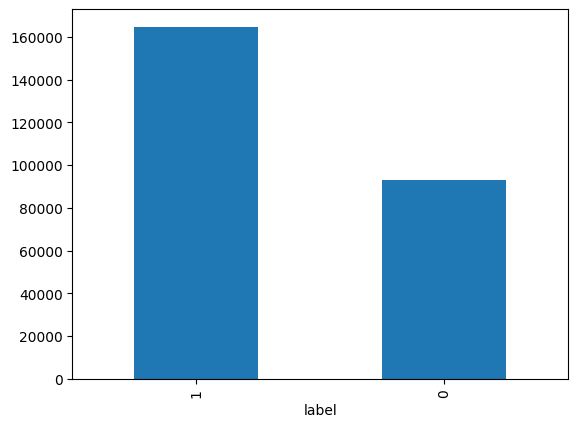

In [9]:
df['label'].value_counts().plot.bar()

In [10]:
df['label'].value_counts(normalize=True)


label
1    0.639077
0    0.360923
Name: proportion, dtype: float64

### Pre-processing and Feature Selection

The first features to drop are 'id', which is just a feature used for indexing and 'attack_cat', which is just an extension of the target feature.

In [11]:
df.drop(['id','attack_cat'],axis=1,inplace=True)

We will use the correlation matrix to find other features that might need to be dropped

<Axes: >

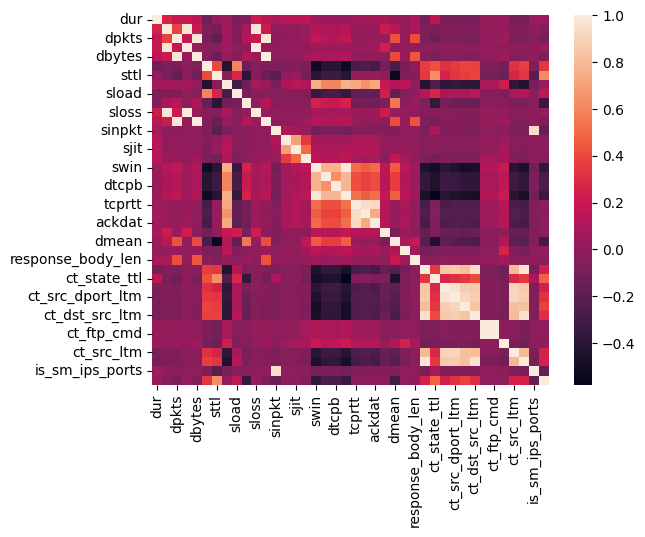

In [12]:
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr())

In [13]:
columns = df.select_dtypes(exclude=['object']).columns.tolist()
corr = df.select_dtypes(include=['int', 'float']).corr()
correlated_vars = []
for i in range(len(columns) - 1):
    for j in range(i+1, len(columns)):
        if corr[columns[i]][columns[j]] > 0.95:
            print(columns[i], columns[j], corr[columns[i]][columns[j]])
            correlated_vars.append(columns[j])

spkts sbytes 0.964393217155871
spkts sloss 0.9718594116510776
dpkts dbytes 0.9734453279792796
dpkts dloss 0.979612084935938
sbytes sloss 0.9957715772406667
dbytes dloss 0.996711133831455
swin dwin 0.9804584289136496
ct_srv_src ct_dst_src_ltm 0.9539519771685965
ct_srv_src ct_srv_dst 0.9794668130725528
ct_dst_ltm ct_src_dport_ltm 0.9615176986568883
ct_dst_src_ltm ct_srv_dst 0.9603212131064117
is_ftp_login ct_ftp_cmd 0.9988554882935726


In [14]:
df = df.drop(columns=correlated_vars)

#### Categorical Features

In [15]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


Some features have very high cardinalities, and this section reduces the cardinality to 5 or 6 per feature. <br> The logic is to take the top 5 occuring labels in the feature as the labels and set the remainder to '-' (seldom used) labels.

In [16]:
for feature in df_cat.columns:
    if df_cat[feature].nunique()>6:
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

In [17]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,6,5,6
top,tcp,-,FIN
freq,123041,149701,117164


In [18]:
df.head()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,74.087490,252,254,14158.942380,8495.365234,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,0,0,1,0,0
1,0.649902,tcp,-,FIN,14,38,78.473372,62,252,8395.112305,503571.312500,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,0,0,1,0,0
2,1.623129,tcp,-,FIN,8,16,14.170161,62,252,1572.271851,60929.230470,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,0,0,2,0,0
3,1.681642,tcp,-,FIN,12,12,13.677108,62,252,2740.178955,3358.622070,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,0,2,0,0
4,0.449454,tcp,-,FIN,10,6,33.373826,254,252,8561.499023,3987.059814,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,1,0,0,2,0,0


In [19]:
df.label.value_counts(normalize=True)

label
1    0.639077
0    0.360923
Name: proportion, dtype: float64

### Train test split dataset

In [20]:
def split_data(df,samples):
    x_0 = df[df.label==0]
    x_1 = df[df.label==1]
    x_0 = x_0.sample(int(0.639077*samples),random_state=123)
    x_1 = x_1.sample(int(0.360923*samples),random_state=123)
    frame = [x_0,x_1]
    new = pd.concat(frame)
    return new

df1 = split_data(df,50000)
df1.reset_index(inplace=True,drop=True)

In [21]:
X = df1.drop(columns='label')
y = df1['label']

In [22]:
train, test, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=42,stratify=y)

In [23]:
train_labels.value_counts(normalize=True)

label
0    0.639075
1    0.360925
Name: proportion, dtype: float64

In [24]:
test_labels.value_counts(normalize=True)

label
0    0.639067
1    0.360933
Name: proportion, dtype: float64

In [25]:
#train = train.astype(np.float32)
train_labels = train_labels.astype(np.float32)
#test = test.astype(np.float32)
test_labels = test_labels.astype(np.float32)

### Model creation and Training

In [26]:
cat_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = X.select_dtypes(exclude=['object']).columns.tolist()

In [27]:
k_folds = 5
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
lr = 0.001
weight_decay = 0.1

feature_dimension = 47
num_classes = 1
network_size = [32,32,32]
layers_size = [feature_dimension, *network_size, num_classes]

nn_model = TorchMLP(layers_size=layers_size)

In [ ]:
from modules.optimizer import *

nn = NeuralNetBinaryClassifier(nn_model,criterion=nn.BCELoss(),optimizer=torch.optim.AdamW, max_epochs=10, batch_size=32,verbose=False)

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

label_encoded_transformer = Pipeline([
    ('label_encoder', OrdinalEncoder())
])

one_hot_encoded_transformer = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
        # ('label',label_encoded_transformer,label_encoded_features),
        ('one_hot', one_hot_encoded_transformer, cat_columns)
    ])
params = {
    "Model__lr": [0.001, 0.01,0.1],
    "preprocessor__num__scaler" : [StandardScaler(),MinMaxScaler()]

}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ('float32', FunctionTransformer(func=convert_to_float32)), 
                        ("Model", nn)])

optimizer = ModelOptimizer(ml_pipeline,param_grid=params,optimization_algorithm='grid_search')
opt = optimizer.optimize(train,train_labels)

In [28]:
import joblib

#joblib.dump(opt, 'optimizer.pkl')

opt = joblib.load('optimizer.pkl')

In [29]:
opt.best_params_

{'Model__lr': 0.001, 'preprocessor__num__scaler': StandardScaler()}

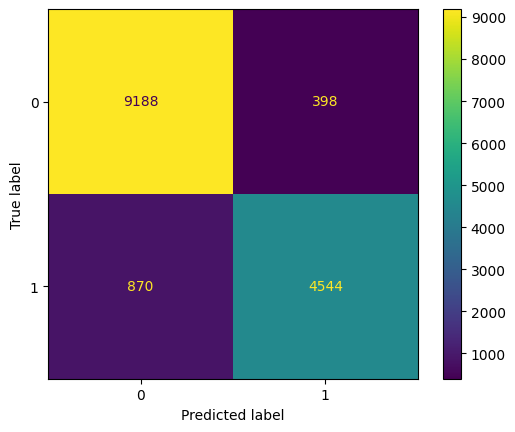

In [30]:
from sklearn.metrics import accuracy_score
#model.eval()
best_estimator = opt.best_estimator_
pred_probabilities = best_estimator.predict(test)

pred_y_test = [1 if prob > 0.5 else 0 for prob in pred_probabilities]
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [31]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      9586
         1.0       0.92      0.84      0.88      5414

    accuracy                           0.92     15000
   macro avg       0.92      0.90      0.91     15000
weighted avg       0.92      0.92      0.91     15000



## Hyperparameter Explainations using PDP and ALE plots

In [32]:
from modules.lib import *
params = {
    "Model__lr": [0.001, 0.01,0.1],
    "preprocessor__num__scaler" : [StandardScaler(),MinMaxScaler()]

}
param_grid = transform_grid(params)
param_space, name = dimensions_aslists(param_grid)
space = Space(param_space)
space.set_transformer_by_type('normalize',Categorical)
hyperparameters = opt.cv_results_['params']
samples = transform_samples(hyperparameters,space,name)

In [33]:
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,Matern
from sklearn.gaussian_process.kernels import WhiteKernel
from skopt.learning.gaussian_process.gpr import GaussianProcessRegressor

# Prepare the hyperparameters and corresponding accuracy scores
n_dims = len(space.dimensions)
is_cat = space.is_categorical
# Convert hyperparameters to a feature matrix (X) and accuracy scores to a target vector (y)
# X = np.array([list(h.values()) for h in hyperparameters])
# X = samples
# y = np.array(accuracy_scores)
X1 , y1 = gaussian_objective('accuracy',opt,samples)
X2 , y2 = gaussian_objective('fit_time',opt,samples)
X3 , y3 = gaussian_objective('score_time',opt,samples)

# if is_cat:
#     other_kernel = HammingKernel(length_scale=np.ones(n_dims))
# else:
#     other_kernel = Matern(
#         length_scale=np.ones(n_dims),
#         length_scale_bounds=[(0.01, 100)] * n_dims, nu=2.5)
# Define the surrogate model with Gaussian Process Regression
kernel = ConstantKernel(1.0, (0.01, 1000.0)) \
        *Matern(
        length_scale=np.ones(n_dims),
        length_scale_bounds=[(0.01, 100)] * n_dims, nu=2.5) + WhiteKernel()

surrogate_model_accuracy = GaussianProcessRegressor(kernel=kernel,normalize_y=True,random_state=1,noise="gaussian",
            n_restarts_optimizer=2)
surrogate_model_fit_time = GaussianProcessRegressor(kernel=kernel,normalize_y=True,random_state=1,noise="gaussian",
            n_restarts_optimizer=2)
surrogate_model_score_time = GaussianProcessRegressor(kernel=kernel,normalize_y=True,random_state=1,noise="gaussian",
            n_restarts_optimizer=2)

# Fit the surrogate model on the hyperparameters and accuracy scores
surrogate_model_accuracy.fit(X1, y1)
surrogate_model_fit_time.fit(X2, y2)
surrogate_model_score_time.fit(X3, y3)

# # Generate new hyperparameters for evaluation
# new_hyperparameters = space.transform([[1, 'auto',2 ,150,'RobustScaler()']])  # Example hyperparameters

# # Predict the accuracy scores using the surrogate model
# predicted_scores = surrogate_model.predict(new_hyperparameters)

# # Print the predicted accuracy scores
# print("Predicted Accuracy Scores:", predicted_scores)


c:\Users\NikolasTheol\Documents\PyEnvs\ExtremeXP\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1)

In [34]:
plot_dims = []
for row in range(space.n_dims):
            if space.dimensions[row].is_constant:
                continue
            plot_dims.append((row, space.dimensions[row]))
            
pdp_samples = space.transform(space.rvs(n_samples=1000,random_state=123456))
x_vals = list(opt.best_params_.values())
data = pd.DataFrame(pdp_samples,columns=[n for n in name])

#### Retrain a PyTorch Neural Network with the best parameters
We retrain the neural network to use it for computing influences.

In [35]:
trainn, val, trainn_labels, val_labels = train_test_split(train,train_labels, test_size=0.2, random_state=42,stratify=train_labels)

In [36]:
def preprocess_data(data,one_hot_encoded_features,numerical_features):

    #one hot encoding of choosen features
    new_data = pd.concat([data, pd.get_dummies(data[one_hot_encoded_features])], axis=1)
    new_data = new_data.drop(columns=one_hot_encoded_features)

    scaler = StandardScaler()
    new_data[numerical_features] = scaler.fit_transform(new_data[numerical_features])
    
    return new_data

In [37]:
new_train = preprocess_data(trainn,cat_columns,numeric_columns)
new_val = preprocess_data(val,cat_columns,numeric_columns)
new_test = preprocess_data(test,cat_columns,numeric_columns)

In [38]:
training_data_loader = DataLoader(
    TensorDataset(
        torch.tensor(new_train.values.astype(np.float32),dtype=torch.float32),
        torch.tensor(trainn_labels.to_numpy(), dtype=torch.float32).unsqueeze(-1),
    ),
    batch_size=32,
    shuffle=True,
)

val_data_loader = DataLoader(
    TensorDataset(
        torch.tensor(new_val.values.astype(np.float32),dtype=torch.float32),
        torch.tensor(val_labels.to_numpy(), dtype=torch.float32).unsqueeze(-1),
    ),
    batch_size=32,
    shuffle=True,
)

In [39]:
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
import torch.nn as nn
from modules.optimizer import *

num_epochs = 10
lr = 0.0001
weight_decay = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


feature_dimension = 47
num_classes = 1
network_size = [32,32,32]
layers_size = [feature_dimension, *network_size, num_classes]

nn_model = TorchMLP(layers_size)
nn_model.to(device)

optimizer = torch.optim.AdamW(params=nn_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.BCELoss()

losses = fit_torch_model(
    model=nn_model,
    training_data=training_data_loader,
    val_data=val_data_loader,
    loss=F.binary_cross_entropy,
    optimizer=optimizer,
    class_weights=None,
    scheduler=scheduler,
    num_epochs=num_epochs,
)

Model fitting:   0%|          | 0/10 [00:00<?, ?it/s]

Model fitting: 100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


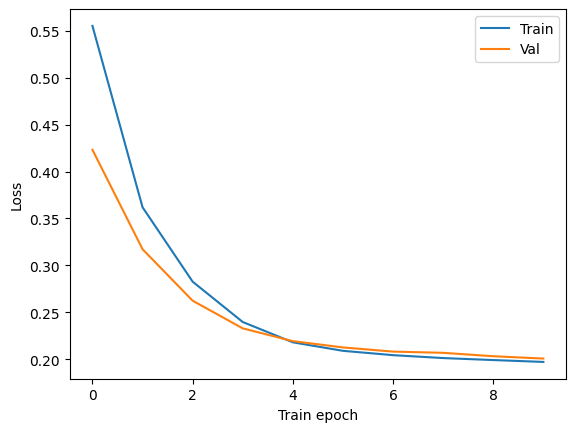

In [40]:
plot_losses(losses)

Accuracy Score is 0.9098666666666667


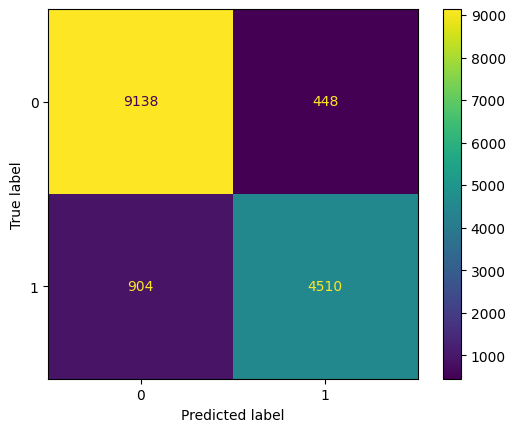

In [41]:
from sklearn.metrics import accuracy_score
nn_model.eval()
pred_probabilities = nn_model(torch.tensor(new_test.values.astype(float), dtype=torch.float)).detach()

pred_y_test = [1 if prob > 0.5 else 0 for prob in pred_probabilities]
print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(torch.tensor(test_labels.to_numpy(), dtype=torch.float64), pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

## Create gRPC Client

In [42]:
new_train.reset_index(drop=True,inplace=True)
trainn.reset_index(drop=True,inplace=True)
new_test.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

trainn_labels.reset_index(drop=True,inplace=True)
test_labels.reset_index(drop=True,inplace=True)

In [43]:
import json
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
import io

class Client():
    def __init__(self):
        self.channel = grpc.insecure_channel('localhost:50051')
        self.stub = xai_service_pb2_grpc.InfluencesStub(self.channel)

    def generate_dataframe_chunks(self,train_data,model, test_data, train_labels,test_labels,num_influential, untransformed_train, untransformed_train_labels, chunk_size=1000):
        print('sending data')
        for i in range(0, len(train_data), chunk_size):
            chunk = train_data[i:i + chunk_size]
            chunk_train = train_labels[i:i + chunk_size]
            chunk_data = chunk.to_parquet(None)
            chunk_train = chunk_train.to_parquet(None)  
            try:
                yield xai_service_pb2.InfluenceRequest(
                    train_data=chunk_data,
                    model=model.getvalue(),
                    test_data=test_data.to_parquet(None),
                    train_labels = chunk_train,
                    test_labels = test_labels.to_frame().to_parquet(None),
                    num_influential = num_influential,
                    untransformed_train = untransformed_train.to_parquet(None),
                    untransformed_train_labels = untransformed_train_labels.to_frame().to_parquet(None)
                )
            except:
                print("error sending data")


    def compute_influences_via_grpc(self,train_data,model, test_data, train_labels,test_labels,num_influential, untransformed_train, untransformed_train_labels):
        # Serialize the PyTorch model and data
        model_bytes = io.BytesIO()
        torch.save(model, model_bytes)

        # Create a sample DataFrame for demonstrdataframe = pd.DataFrame(sample_data)
        try:    
            response = self.stub.ComputeInfluences(self.generate_dataframe_chunks(train_data,model_bytes, test_data, train_labels,test_labels,num_influential, untransformed_train, untransformed_train_labels))
            return response.influences, response.positive, response.negative
        except grpc.RpcError as e:
            print(f"Error calling StreamDataFrame: {e}")
            return None, None, None

    def run_explanations_client(self,explanation_type,param_grid,model,feature1=None,feature2=None):
        channel = grpc.insecure_channel('localhost:50051')  # Adjust the address based on your server configuration

        # Create a stub for the Explanations service
        explanations_stub = xai_service_pb2_grpc.ExplanationsStub(channel)
        model_bytes = io.BytesIO()
        torch.save(model, model_bytes)
        # Prepare an ExplanationsRequest for ComputePDP
        if explanation_type == 'ComputePDP2D':
            explanations_request = xai_service_pb2.ExplanationsRequest(
                explanation_type=explanation_type,
                param_grid=json.dumps(param_grid),
                model=model_bytes.getvalue(),
                feature1 = feature1,
                feature2 = feature2
            )
        else:
            explanations_request = xai_service_pb2.ExplanationsRequest(
                explanation_type=explanation_type,
                param_grid=json.dumps(param_grid),
                model=model_bytes.getvalue()
            )    

        # Make a gRPC call to the Explanations service
        explanations_response = explanations_stub.GetExplanation(explanations_request)
        if explanation_type == 'ComputePDP':
            return explanations_response.pdp_hp_values, explanations_response.pdp_values
        elif explanation_type == 'ComputeALE':
            return explanations_response.ale_data
        else:
            return explanations_response.pdp2d_xi, explanations_response.pdp2d_yi, explanations_response.pdp2d_zi

### Compute PDP 1D Plots via gRPC

In [44]:
client = Client()
xi,yi = client.run_explanations_client('ComputePDP',param_grid,surrogate_model_accuracy)
xi = json.loads(xi)
yi = json.loads(yi)

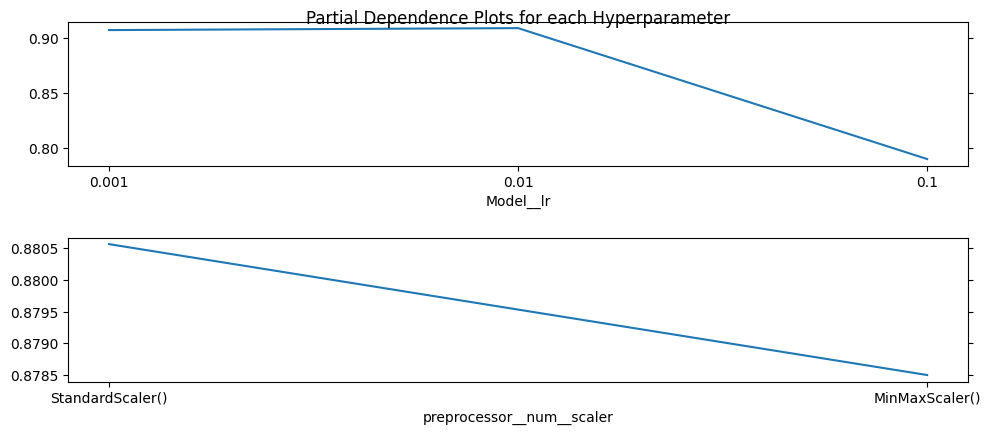

In [45]:
plot_pdp_1D_grpc(xi,yi,param_grid)

### Compute PDP 2D Plots via gRPC

In [46]:
xi , yi , zi= client.run_explanations_client('ComputePDP2D',param_grid,surrogate_model_accuracy,'Model__lr','preprocessor__num__scaler')
xi = np.array(json.loads(xi))
yi = np.array(json.loads(yi))
zi = np.array(json.loads(zi))

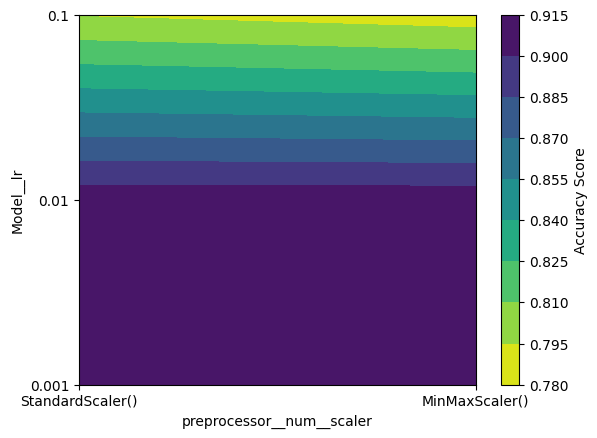

In [47]:
plot_pdp_2D_grpc(xi,yi,zi,param_grid,'Model__lr','preprocessor__num__scaler')

### Compute ALE Plots via gRPC

In [48]:
d = client.run_explanations_client('ComputeALE',param_grid,surrogate_model_accuracy)
json_data_list = json.loads(d)

# Create a list to store dataframes
dataframes_list_deserialized = []

# Convert each dictionary back into a dataframe
for json_data in json_data_list:
    df = pd.read_json(json_data, orient='split')
    dataframes_list_deserialized.append(df)

C:\Users\NikolasTheol\AppData\Local\Temp\ipykernel_11900\2892729756.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json_data, orient='split')
C:\Users\NikolasTheol\AppData\Local\Temp\ipykernel_11900\2892729756.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json_data, orient='split')


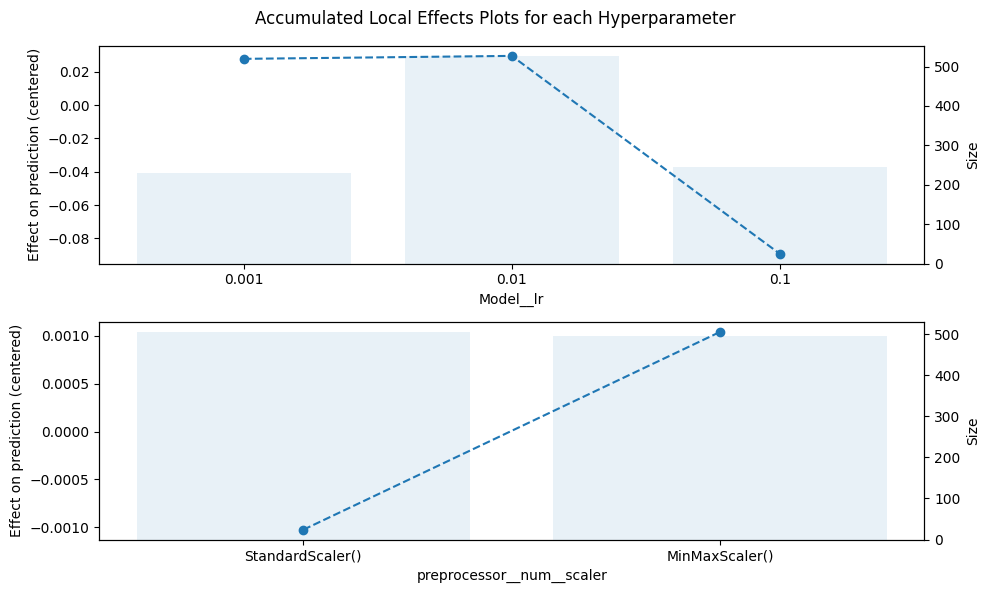

In [49]:
plot_ale_grpc(dataframes_list_deserialized,param_grid)

### Compute Influence Functions via gRPC

In [50]:
# Compute influences via gRPC
client = Client()
inf, positive, negative = client.compute_influences_via_grpc(new_train.loc[:1999],nn_model, new_test.iloc[[27,104,128,136]], trainn_labels.to_frame().loc[:1999], test_labels.loc[[27,104,128,136]],5, trainn.loc[0:1999], trainn_labels.loc[0:1999])
# inf = pd.DataFrame(np.array(influences).reshape(6,5000),columns=[str(i) for i in range(0, 5000)])
positive =  pd.read_parquet(io.BytesIO(positive))
negative =  pd.read_parquet(io.BytesIO(negative))

sending data
Error calling StreamDataFrame: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool."
	debug_error_string = "UNKNOWN:Error received from peer ipv6:%5B::1%5D:50051 {created_time:"2024-01-18T13:20:37.8381015+00:00", grpc_status:2, grpc_message:"Exception calling application: can\'t convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool."}"
>


ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet file size is 0 bytes

In [61]:
train_data_loader = DataLoader(
                        TensorDataset(
                        torch.tensor(new_train.loc[:500].values.astype(np.float32), dtype=torch.float), 
                        torch.tensor(trainn_labels.to_frame().loc[:500].squeeze().to_numpy().astype(float), dtype=torch.float)),
                        batch_size=32,
)

In [62]:
training_data = (torch.tensor(new_train.loc[:500].values.astype(np.float32), dtype=torch.float32), torch.tensor(trainn_labels.to_frame().loc[:500].squeeze().to_numpy(), dtype=torch.float32))
test_data = (torch.tensor(new_test.iloc[[27,104,128,136]].values.astype(np.float32), dtype=torch.float32), torch.tensor(test_labels.loc[[27,104,128,136]].squeeze().to_numpy(), dtype=torch.float32).unsqueeze(-1))

influence_model = DirectInfluence(
                        nn_model,
                        F.binary_cross_entropy,
                        hessian_regularization=0.5,
                )
influence_model = influence_model.fit(train_data_loader)
influence_values = influence_model.influences(*test_data, *training_data, mode="up")

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.

In [51]:
positive

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,service_smtp,state_-,state_CON,state_FIN,state_INT,state_REQ,state_RST,label,influence
4879,2.153629,1.868301,4.025048,-0.438835,-1.023182,-0.507467,-0.300623,-0.257795,-0.161815,-0.065686,0.381364,3.704151,0.847325,1.813405,0.342483,-0.422894,-0.367180,-0.422323,-0.408841,3.865743,-0.329455,-0.05274,-0.631758,-0.932836,-0.287453,-0.377717,-0.114929,-0.205974,-0.366708,-0.161184,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,43.418873
506,0.079792,0.335558,-0.086493,-0.438866,1.002960,1.565876,-0.298750,-0.364018,-0.165199,-0.011124,-0.054407,-0.103522,0.847325,1.994753,-0.777626,1.373783,1.018617,1.593933,4.919891,-0.424441,-0.329455,-0.05274,-0.631758,-0.047704,-0.584404,-0.377717,-0.114929,-0.205974,-0.653277,-0.161184,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.0,39.544205
523,2.272857,2.233240,0.244769,-0.439038,1.002960,1.565876,-0.299539,-0.364637,-0.162481,0.124814,0.275206,0.171489,0.847325,0.845529,0.879933,0.308409,0.263433,0.313531,5.537786,-0.417338,-0.329455,-0.05274,-0.739154,-0.047704,-0.584404,-0.377717,-0.114929,-0.205974,-0.653277,-0.161184,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,32.951336
2157,0.171573,0.335558,-0.105979,-0.438955,1.002960,1.565876,-0.299210,-0.364372,-0.164288,0.029674,-0.030955,-0.075727,0.847325,0.794680,0.787991,2.301680,1.288549,3.203395,4.924834,-0.424441,2.992259,-0.05274,-0.739154,-0.047704,-0.584404,-0.377717,-0.114929,1.344315,-0.509993,-0.161184,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.0,29.081726
2609,0.061536,0.809979,-0.047521,-0.438573,1.002960,1.565876,-0.296564,-0.363656,-0.166747,-0.030986,-0.084009,-0.121421,0.847325,0.470241,0.656683,0.698179,0.813686,0.432775,5.290628,-0.424441,-0.329455,-0.05274,-0.631758,-0.047704,-0.584404,-0.377717,-0.114929,-0.205974,1.782556,-0.161184,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,27.603422


In [52]:
negative

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,service_smtp,state_-,state_CON,state_FIN,state_INT,state_REQ,state_RST,label,influence
4004,-0.173474,-0.175356,-0.203409,-0.438964,1.002960,-0.219245,-0.300274,-0.340295,-0.160408,-0.078535,-0.109096,-0.136515,-1.180289,-0.855374,-0.854440,-0.428361,-0.374330,-0.424720,2.285184,1.827195,-0.329455,-0.05274,-0.739154,-0.932836,-0.584404,-0.377717,-0.114929,-0.205974,-0.653277,-0.161184,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1.0,-54.879803
4074,0.034703,0.116595,-0.105979,-0.438943,1.002960,1.565876,-0.299527,-0.363318,-0.164047,-0.015038,-0.042336,-0.111936,0.847325,1.702853,0.999120,1.854701,1.316296,2.226999,4.069666,-0.328552,-0.329455,-0.05274,-0.416964,-0.047704,-0.584404,-0.377717,-0.114929,-0.205974,-0.509993,-0.161184,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,-50.424999
3277,0.187251,2.142005,0.166825,-0.438217,-0.741521,1.565876,-0.293781,-0.362998,-0.167316,-0.049022,-0.091529,-0.126157,0.847325,0.327066,0.553305,1.203766,0.851612,1.448854,5.641593,-0.427993,2.992259,-0.05274,-0.631758,-0.047704,-0.435929,-0.377717,-0.114929,1.344315,1.639272,-0.161184,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,-41.936890
2156,0.093920,0.536275,-0.086493,-0.438787,1.002960,1.565876,-0.297971,-0.364066,-0.165917,-0.008344,-0.063278,-0.102972,0.847325,0.320823,1.645501,1.384356,1.377462,1.158812,5.335117,-0.424441,-0.329455,-0.05274,-0.416964,-0.047704,-0.584404,-0.377717,-0.114929,-0.205974,-0.653277,-0.161184,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,-41.210423
4881,-0.189167,-0.175356,-0.203409,-0.438794,1.002960,-0.219245,-0.300128,-0.329283,-0.163636,-0.079463,-0.109898,-0.136879,-1.180289,-0.855374,-0.854440,-0.428361,-0.374330,-0.424720,1.701890,1.464944,-0.329455,-0.05274,-0.739154,-0.932836,-0.584404,-0.377717,-0.114929,-0.205974,-0.653277,-0.161184,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1.0,-40.543510
